In [2]:
import os
import json
import random
from typing import Optional
import torch
from torch import nn
from torch.nn import functional as F
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tools import utils

In [11]:
log_path = 'runs'
records = []
questions = [
    "What kind of road scene is it in the images?",
    "What is the point cloud data quality in current road area of this image?",
    "How many lanes in current road?", 
    "Is there any road cross, intersection or lane change zone in the main road?"
]
abb = ["SCN", "QLT", "LAN", "INT"]
for file in os.listdir(log_path):
    json_data = json.load(open(os.path.join(log_path, file)))
    model = file.split('_')[0] + '_' + file.split('_')[1]
    for key in json_data.keys():
        for question in questions:
            if question.lower() in key.lower():
                records.append({
                    "question": question,
                    "model": model,
                    "abb": abb[questions.index(question)],
                    "correct": json_data[key]['correct'],
                    "total": json_data[key]['total'],
                    "accuracy": json_data[key]['correct'] / json_data[key]['total'],
                    })
records_df = pd.DataFrame(records)

In [12]:
records_df

,question,model,abb,correct,total,accuracy
0,How many lanes in current road?,clip_zero,LAN,404,1500,0.269333
1,"Is there any road cross, intersection or lane ...",clip_zero,INT,24,1500,0.016000
2,What is the point cloud data quality in curren...,clip_zero,QLT,1167,1500,0.778000
3,What kind of road scene is it in the images?,clip_zero,SCN,42,1500,0.028000
4,How many lanes in current road?,exp_random,LAN,307,1500,0.204667
5,"Is there any road cross, intersection or lane ...",exp_random,INT,259,1500,0.172667
6,What is the point cloud data quality in curren...,exp_random,QLT,351,1500,0.234000
7,What kind of road scene is it in the images?,exp_random,SCN,217,1500,0.144667
8,What kind of road scene is it in the images?,ViLT_pretrained,SCN,13,1500,0.008667
9,How many lanes in current road?,ViLT_mixft,LAN,526,1776,0.296171


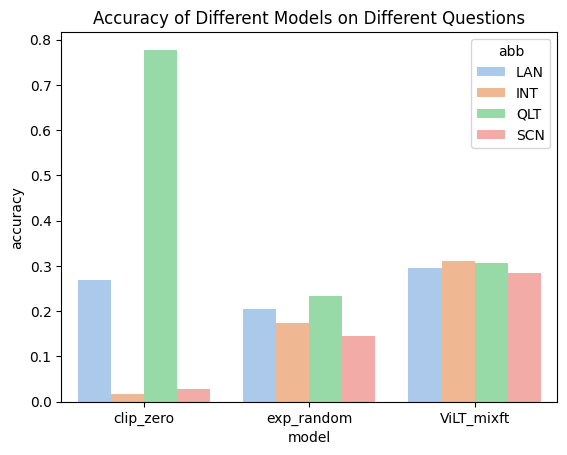

In [14]:
all_models = ["clip_zero", "exp_random", "ViLT_mixft"]
records_all = records_df[records_df['model'].isin(all_models)]
sns.barplot(data=records_all, x='model', y='accuracy', hue='abb', palette='pastel')
plt.title("Accuracy of Different Models on Different Questions")
plt.show()

/tmp/ipykernel_28450/3447784450.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=records_df[records_df['question'] == question], x='model', y='accuracy', palette='pastel', legend=False)


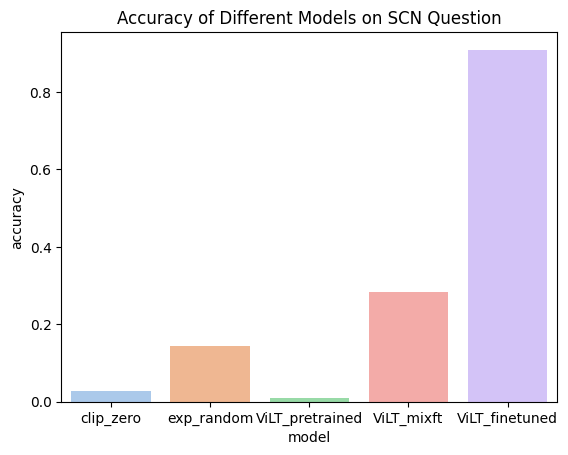

In [21]:
question = "What kind of road scene is it in the images?"
sns.barplot(data=records_df[records_df['question'] == question], x='model', y='accuracy', palette='pastel', legend=False)
plt.title("Accuracy of Different Models on SCN Question")
plt.show()

In [22]:
class Arguments:
    def __init__(self):
        self.data_root = 'data/maplm_v0.1'
        self.output_dir = 'runs'
        self.test_split = 'train'
        self.test_number = -1
        self.exp_label = 'transformer'
        self.random_seed = 42
        self.debug = False

arguments = Arguments()
random.seed(arguments.random_seed)

In [23]:
frames, frame_ids = utils.load_data(arguments)
result_file_name = utils.get_result_file(arguments)

Number of test frames: 10775



In [32]:
choices_set = set()
choices_counter = Counter()

for frame_id in frame_ids:
    frame = frames[frame_id]
    for qa in frame['qa']:
        if qa['task'] != 'closed choice':
            continue
        choices = qa['choices']
        for choice in choices:
            choices_set.add(choice)
        ans = choices[int(qa['answer'])]
        choices_counter[ans] += 1


In [33]:
choices_counter

Counter({'Normal city road.': 9814,
         'Very clear.': 8964,
         'No.': 7985,
         '2': 5170,
         '3': 2524,
         'Yes, there is a small road intersection in the image.': 1676,
         '4': 1622,
         'Not clear, road mark is worn.': 1354,
         'Undeveloped road.': 706,
         '1': 627,
         '0': 593,
         'Yes, there is one lane change zone in the image.': 500,
         'Not clear, road mark is occluded by some vehicle.': 390,
         'Yes, there is one crossroad in the image.': 374,
         'Construction road.': 236,
         'Yes, there is one T-junction in the image.': 204,
         '5': 140,
         '6': 70,
         'Not clear, road mark is worn and occluded by vehicle.': 67,
         'Yes, there is one irregular intersection in the image.': 36,
         '8': 18,
         'Road mark repainting.': 15,
         '7': 8,
         'Roundabout.': 4,
         '10': 1,
         '9': 1,
         '12': 1})

In [15]:
choices_list = list(choices_set)
choices_list.sort()
choices_list

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'Construction road.',
 'No.',
 'None of the above.',
 'Normal city road.',
 'Not clear, road mark is occluded by some vehicle.',
 'Not clear, road mark is worn and occluded by vehicle.',
 'Not clear, road mark is worn.',
 'Road mark repainting.',
 'Roundabout.',
 'Undeveloped road.',
 'Very clear.',
 'Yes, there is a small road intersection in the image.',
 'Yes, there is one T-junction in the image.',
 'Yes, there is one crossroad in the image.',
 'Yes, there is one irregular intersection in the image.',
 'Yes, there is one lane change zone in the image.']

In [7]:
frame = frames[frame_ids[0]]

image = frame['image']
qas = frame['qa']

corrects = []

In [9]:
qa = qas[0]
if qa['task'] != 'closed choice':
    pass
question = qa['question']
choices = qa['choices']
true_answer: int = qa['answer']

In [3]:
class CLIPVisionEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.class_embedding = nn.Parameter(torch.randn(self.embed_dim))

        self.patch_embedding = nn.Conv2d(
            in_channels=3, out_channels=self.embed_dim, kernel_size=self.patch_size, stride=self.patch_size, bias=False
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches + 1
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer("position_ids", torch.arange(self.num_positions).expand((1, -1)))

    def forward(self, pixel_values):
        batch_size = pixel_values.shape[0]
        patch_embeds = self.patch_embedding(pixel_values)  # shape = [*, width, grid, grid]
        patch_embeds = patch_embeds.flatten(2).transpose(1, 2)

        class_embeds = self.class_embedding.expand(batch_size, 1, -1)
        embeddings = torch.cat([class_embeds, patch_embeds], dim=1)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        return embeddings

In [4]:
class CLIPTextEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size

        self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(config.max_position_embeddings, embed_dim)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))

    def forward(self, input_ids=None, position_ids=None, inputs_embeds=None):
        seq_length = input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        if inputs_embeds is None:
            inputs_embeds = self.token_embedding(input_ids)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings

        return embeddings

In [ ]:
class CLIPAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        assert (
            self.head_dim * self.num_heads == self.embed_dim
        ), f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`: {self.num_heads})."
        self.scale = self.head_dim ** -0.5
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def _shape(self, tensor, seq_len, bsz):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).countiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ):
        bsz, tgt_len, embed_dim = hidden_states.size()

        query_states = self.q_proj(hidden_states) * self.scale
        key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
        value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(
            query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is {attn_weights.size()}"
            )

        if causal_attention_mask is not None:
            if causal_attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {causal_attention_mask.size()}"
                )
            attn_weights = attn_weights.view(
                bsz, self.num_heads, tgt_len, src_len) + causal_attention_mask
            attn_weights = attn_weights.view(
                bsz * self.num_heads, tgt_len, src_len)

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {causal_attention_mask.size()}"
                )
            attn_weights = attn_weights.view(
                bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(
                bsz * self.num_heads, tgt_len, src_len)

        attn_weights = F.softmax(attn_weights, dim=-1)

        if output_attentions:
            # this operation is a bit akward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(
                bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(
                bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = F.dropout(
            attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is {attn_output.size()}"
            )

        attn_output = attn_output.view(
            bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped

In [6]:
class CLIPMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.activation_fn = F.gelu
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states):
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states

In [ ]:
class CLIPEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = CLIPAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim)
        self.mlp = CLIPMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        causal_attention_mask: torch.Tensor,
        output_attentions: bool = False,
    ):
        """
        Args:
            hidden_states (:obj:`torch.FloatTensor`): input to the layer of shape :obj:`(seq_len, batch, embed_dim)`
            attention_mask (:obj:`torch.FloatTensor`): attention mask of size
                :obj:`(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (:obj:`torch.FloatTensor`): mask for attention heads in a given layer of size
                :obj:`(config.encoder_attention_heads,)`.
            output_attentions (:obj:`bool`, `optional`):
                Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under
                returned tensors for more detail.
        """
        residual = hidden_states

        hidden_states = self.layer_norm1(hidden_states)
        hidden_states, attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
        )
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs

In [ ]:
class CLIPEncoder(nn.Module):
    """
    Transformer encoder consisting of :obj:`config.num_hidden_layers` self attention layers. Each layer is a
    :class:`~transformers.CLIPEncoderLayer`.

    Args:
        config: CLIPConfig
        embed_tokens (torch.nn.Embedding): output embedding
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([CLIPEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(
        self,
        inputs_embeds,
        attention_mask=None,
        causal_attention_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Args:
            inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
                Optionally, instead of passing :obj:`input_ids` you can choose to directly pass an embedded
                representation. This is useful if you want more control over how to convert :obj:`input_ids` indices
                into associated vectors than the model's internal embedding lookup matrix.
            attention_mask (:obj:`torch.Tensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
                Mask to avoid performing attention on padding token indices. Mask values selected in ``[0, 1]``:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                `What are attention masks? <../glossary.html#attention-mask>`__
            causal_attention_mask (:obj:`torch.Tensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
                Causal mask for the text model. Mask values selected in ``[0, 1]``:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                `What are attention masks? <../glossary.html#attention-mask>`__
            output_attentions (:obj:`bool`, `optional`):
                Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under
                returned tensors for more detail.
            output_hidden_states (:obj:`bool`, `optional`):
                Whether or not to return the hidden states of all layers. See ``hidden_states`` under returned tensors
                for more detail.
            return_dict (:obj:`bool`, `optional`):
                Whether or not to return a :class:`~transformers.file_utils.ModelOutput` instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        hidden_states = inputs_embeds
        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            if getattr(self.config, "gradient_checkpointing", False) and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(encoder_layer),
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                )
            else:
                layer_outputs = encoder_layer(
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                    output_attentions=output_attentions,
                )

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )